In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from statsmodels.formula.api import ols
import statsmodels.graphics.gofplots as sm
from scipy import stats
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
from scipy.stats import permutation_test
from statsmodels.stats.power import TTestIndPower
from pathlib import Path
import numpy as np
%matplotlib inline

In [2]:
def ols_two_cols(df: pd.DataFrame, x: str, y: str):
    model = ols(f'{x} ~ {y}', data=df)
    res = model.fit()
    fig, axs = plt.subplots(2,2, squeeze=False)
    df['Prediction'] = res.predict(df)
    plt.tight_layout()
    
    ax = df.plot.scatter(x=f'{y}',y=f'{x}', ax=axs[0,0])
    df.plot(x=f'{x}',y='Prediction', ax=axs[0,0], color='red')
    # plt.subplot(2,2,2)
    residuals = res.predict(df)-df[f'{x}']
    axs[0,1].scatter(df[f'{y}'], (residuals))
    axs[0,1].set_xlabel(f'{y}')
    axs[0,1].set_ylabel('Residual values')
    
    axs[1,0].hist(residuals)
    axs[1,0].set_ylabel('frequency')
    axs[1,0].set_xlabel('residuual values')
    plt.subplot(2,2,4)
    sm.qqplot(residuals, stats.t, distargs=(4,), loc=3, scale=10, fit=True, ax=axs[1,1], line='s')
    plt.tight_layout()
    
    return model, res


In [3]:
def ols_two_cols_C(df: pd.DataFrame, x: str, y: str):
    model = ols(f'{x} ~ C({y})', data=df)
    res = model.fit()
    fig, axs = plt.subplots(2,2, squeeze=False)
    df['Prediction'] = res.predict(df)
    plt.tight_layout()
    
    ax = df.plot.scatter(x=f'{y}',y=f'{x}', ax=axs[0,0])
    df.plot(x=f'{x}',y='Prediction', ax=axs[0,0], color='red')
    # plt.subplot(2,2,2)
    residuals = res.predict(df)-df[f'{x}']
    axs[0,1].scatter(df[f'{y}'], (residuals))
    axs[0,1].set_xlabel(f'{y}')
    axs[0,1].set_ylabel('Residual values')
    
    axs[1,0].hist(residuals)
    axs[1,0].set_ylabel('frequency')
    axs[1,0].set_xlabel('residuual values')
    plt.subplot(2,2,4)
    sm.qqplot(residuals, stats.t, distargs=(4,), loc=3, scale=10, fit=True, ax=axs[1,1], line='s')
    plt.tight_layout()
    
    return model, res

In [ ]:
def ols_two_cols_C(df: pd.DataFrame, query: str, x, y):
    model = ols(query, data=df)
    res = model.fit()
    fig, axs = plt.subplots(2,2, squeeze=False)
    df['Prediction'] = res.predict(df)
    plt.tight_layout()
    
    ax = df.plot.scatter(x=f'{y}',y=f'{x}', ax=axs[0,0])
    df.plot(x=f'{x}',y='Prediction', ax=axs[0,0], color='red')
    # plt.subplot(2,2,2)
    residuals = res.predict(df)-df[f'{x}']
    axs[0,1].scatter(df[f'{y}'], (residuals))
    axs[0,1].set_xlabel(f'{y}')
    axs[0,1].set_ylabel('Residual values')
    
    axs[1,0].hist(residuals)
    axs[1,0].set_ylabel('frequency')
    axs[1,0].set_xlabel('residuual values')
    plt.subplot(2,2,4)
    sm.qqplot(residuals, stats.t, distargs=(4,), loc=3, scale=10, fit=True, ax=axs[1,1], line='s')
    plt.tight_layout()
    
    return model, res

In [4]:
def correlation_map(f_data, f_feature, f_number):
    f_most_correlated = f_data.corr().nlargest(f_number,f_feature)[f_feature].index
    f_correlation = f_data[f_most_correlated].corr()
    
    f_mask = np.zeros_like(f_correlation)
    f_mask[np.triu_indices_from(f_mask)] = True
    with sns.axes_style("white"):
        f_fig, f_ax = plt.subplots(figsize=(8, 6))
        f_ax = sns.heatmap(f_correlation, mask=f_mask, vmin=0, vmax=1, square=True,
                           annot=True, annot_kws={"size": 10}, cmap="BuPu")

    plt.show()

In [5]:
def read_store_csvs(path: Path):
    file_paths = [f for f in path.glob('store*.csv')]
    files = [pd.read_csv(f, low_memory=False) for f in file_paths]
    return file_paths, files

csvs_dir = Path("data")
file_paths, files = read_store_csvs(csvs_dir)
for file in files:
    file.set_index('Store', inplace=True)
stores_df = pd.concat([files[0], files[2]], axis=1)
store_data = files[1]
state_names = pd.read_csv(csvs_dir / 'state_names.csv')


In [6]:
def clear_df_from_nans(df: pd.DataFrame):
    df.CompetitionDistance = df.CompetitionDistance.fillna(stores_df.CompetitionDistance.mean())
    df.CompetitionOpenSinceMonth = df.CompetitionOpenSinceMonth.fillna(method='bfill', axis=0)
    df.CompetitionOpenSinceMonth.dropna(axis=0, inplace=True)
    df.CompetitionOpenSinceYear = df.CompetitionOpenSinceYear.fillna(method='bfill', axis=0)
    df.CompetitionOpenSinceYear.dropna(axis=0, inplace=True)
    df.Promo2SinceWeek = df.Promo2SinceWeek.fillna(method='bfill', axis=0)
    df.Promo2SinceWeek.dropna(axis=0, inplace=True)
    df.Promo2SinceYear = df.Promo2SinceYear.fillna(method='bfill', axis=0)
    df.Promo2SinceYear.dropna(axis=0, inplace=True)
    df.PromoInterval = df.PromoInterval.fillna(method='bfill', axis=0)
    df.PromoInterval.dropna(axis=0, inplace=True)
    return df
    

In [7]:
def map_string_column(df: pd.DataFrame, column_name: str):
    # unique_label_list = sorted(df[column_name].unique())
    unique_label_list = df[column_name].unique()
    label_dict = { unique_label_list[i]: i for i in range(len(unique_label_list)) }
    df[column_name] = df[column_name].map(label_dict)
    return df, label_dict

In [8]:
store_data, holidays_dict = map_string_column(store_data, 'StateHoliday')
store_data.Date = pd.to_datetime(store_data.Date)
store_data

,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Store,,,,,,,,
1,5,2015-07-31,5263,555,1,1,0,1
2,5,2015-07-31,6064,625,1,1,0,1
3,5,2015-07-31,8314,821,1,1,0,1
4,5,2015-07-31,13995,1498,1,1,0,1
5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...
1111,2,2013-01-01,0,0,0,0,1,1
1112,2,2013-01-01,0,0,0,0,1,1
1113,2,2013-01-01,0,0,0,0,1,1


In [9]:
stores_df['Assortment'] = pd.Series(stores_df['Assortment'], dtype='string')
stores_df['StoreType'] = pd.Series(stores_df['StoreType'], dtype='string')
stores_df.reset_index(inplace=True)
stores_df, states_dict = map_string_column(stores_df, 'State')
stores_df, store_type_dict = map_string_column(stores_df, 'StoreType')
stores_df, assortment_dict = map_string_column(stores_df, 'Assortment')
stores_df, promo_interval_dict = map_string_column(stores_df, 'PromoInterval')
stores_df.CompetitionDistance = stores_df.CompetitionDistance.fillna(stores_df.CompetitionDistance.mean())
stores_df.CompetitionOpenSinceMonth = stores_df.CompetitionOpenSinceMonth.fillna(method='bfill', axis=0)
stores_df.CompetitionOpenSinceMonth.dropna(axis=0, inplace=True)
stores_df.CompetitionOpenSinceYear = stores_df.CompetitionOpenSinceYear.fillna(method='bfill', axis=0)
stores_df.CompetitionOpenSinceYear.dropna(axis=0, inplace=True)
stores_df.Promo2SinceWeek = stores_df.Promo2SinceWeek.fillna(method='bfill', axis=0)
stores_df.Promo2SinceWeek.dropna(axis=0, inplace=True)
stores_df.Promo2SinceYear = stores_df.Promo2SinceYear.fillna(method='bfill', axis=0)
stores_df.Promo2SinceYear.dropna(axis=0, inplace=True)
stores_df.PromoInterval = stores_df.PromoInterval.fillna(method='bfill', axis=0)
stores_df.PromoInterval.dropna(axis=0, inplace=True)
stores_df

C:\Users\szymo\AppData\Local\Temp\ipykernel_19552\3373014831.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  stores_df.CompetitionDistance.fillna(stores_df.CompetitionDistance.mean(),inplace = True)
C:\Users\szymo\AppData\Local\Temp\ipykernel_19552\3373014831.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting 

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,State
0,1,0,0,1270.0,9.0,2008.0,0,13.0,2010.0,0,0
1,2,1,0,570.0,11.0,2007.0,1,13.0,2010.0,1,1
2,3,1,0,14130.0,12.0,2006.0,1,14.0,2011.0,1,2
3,4,0,1,620.0,9.0,2009.0,0,1.0,2012.0,0,3
4,5,1,0,29910.0,4.0,2015.0,0,1.0,2012.0,0,4
...,...,...,...,...,...,...,...,...,...,...,...
1110,1111,1,0,1900.0,6.0,2014.0,1,31.0,2013.0,1,2
1111,1112,0,1,1880.0,4.0,2006.0,0,22.0,2012.0,0,2
1112,1113,1,1,9260.0,NaN,NaN,0,22.0,2012.0,0,5
1113,1114,1,1,870.0,NaN,NaN,0,22.0,2012.0,0,11


In [10]:
states_dict

{'HE': 0,
 'TH': 1,
 'NW': 2,
 'BE': 3,
 'SN': 4,
 'SH': 5,
 'HB,NI': 6,
 'BY': 7,
 'BW': 8,
 'RP': 9,
 'ST': 10,
 'HH': 11}

In [11]:
state_names = pd.read_csv(csvs_dir / 'state_names.csv')
state_names['Numeric'] = state_names['State'].map(states_dict)
state_names.sort_values(by='Numeric', ascending=True, inplace=True)
state_names['Numeric'] = pd.Series(state_names['Numeric'], dtype='int')
state_names.dropna(inplace=True)
state_names

,StateName,State,Numeric
6,Hessen,HE,0.0
15,Thueringen,TH,1.0
9,NordrheinWestfalen,NW,2.0
2,Berlin,BE,3.0
12,Sachsen,SN,4.0
14,SchleswigHolstein,SH,5.0
8,Niedersachsen,"HB,NI",6.0
1,Bayern,BY,7.0
0,BadenWuerttemberg,BW,8.0
10,RheinlandPfalz,RP,9.0


In [48]:
weather = pd.read_csv(csvs_dir / 'weather.csv')
weather.Date = pd.to_datetime(weather.Date)
weather['State'] = pd.Series(weather['State'], dtype='string')
statename_to_state_id_dict = state_names[['StateName', 'Numeric']].set_index('StateName').to_dict()['Numeric']
weather['State'] = weather['State'].map(statename_to_state_id_dict)
weather.dropna(inplace=True)
weather['State'] = pd.Series(weather['State'], dtype='int')
stores_df, weather_event_dict = map_string_column(weather, 'Events')
weather

,State,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,...,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,2,2013-01-01,8,4,2,7,5,1,94,87,...,31.0,12.0,4.0,39,26,58.0,5.08,6.0,0,215
24,2,2013-01-25,-2,-2,-3,-3,-4,-6,95,83,...,26.0,9.0,1.0,23,8,40.0,0.00,7.0,1,80
25,2,2013-01-26,0,-2,-4,-1,-4,-6,100,81,...,26.0,11.0,3.0,34,24,48.0,0.00,7.0,2,158
26,2,2013-01-27,4,2,-1,3,1,-2,95,86,...,26.0,12.0,5.0,35,21,53.0,3.05,7.0,2,174
28,2,2013-01-29,12,8,3,10,8,3,96,88,...,31.0,12.0,6.0,45,31,61.0,6.10,7.0,0,216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14833,1,2015-09-01,27,21,14,17,13,11,88,64,...,31.0,14.0,10.0,43,13,52.0,0.00,6.0,0,266
14838,1,2015-09-06,15,11,7,9,7,6,88,75,...,31.0,11.0,10.0,42,27,60.0,0.00,4.0,0,269
14842,1,2015-09-10,16,12,8,9,8,6,94,81,...,31.0,13.0,6.0,26,8,45.0,2.03,6.0,3,36
14846,1,2015-09-14,19,16,12,15,12,10,98,78,...,26.0,11.0,5.0,42,13,61.0,8.89,6.0,3,202


# Analiza pod kątem zamknięcia sklepu

In [13]:
closed_count = store_data[store_data['Open'] == 0].count()[0]
print('Ilość zamkniętych sklepów (łącznie): ', closed_count)
national_holiday = store_data[store_data['StateHoliday'] == holidays_dict['a']].count()[0]
print('Ilość zamkniętych w święta państwowe i procentowy udział (łącznie): ', national_holiday, " | ", national_holiday/float(closed_count))
easter_holiday = store_data[store_data['StateHoliday'] == holidays_dict['b']].count()[0]
print('Ilość zamkniętych w święta wielkanocne i procentowy udział (łącznie): ', easter_holiday, " | ", easter_holiday/float(closed_count))
xmas_holiday = store_data[store_data['StateHoliday'] == holidays_dict['c']].count()[0]
print('Ilość zamkniętych w święta bożego narodzenia i procentowy udział (łącznie): ', xmas_holiday, " | ", xmas_holiday/float(closed_count))

Ilość zamkniętych sklepów (łącznie):  172817
Ilość zamkniętych w święta państwowe i procentowy udział (łącznie):  20260  |  0.11723383694891128
Ilość zamkniętych w święta wielkanocne i procentowy udział (łącznie):  6690  |  0.038711469357759945
Ilość zamkniętych w święta bożego narodzenia i procentowy udział (łącznie):  4100  |  0.02372451784257336


C:\Users\szymo\AppData\Local\Temp\ipykernel_19552\3996494325.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  closed_count = store_data[store_data['Open'] == 0].count()[0]
C:\Users\szymo\AppData\Local\Temp\ipykernel_19552\3996494325.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  national_holiday = store_data[store_data['StateHoliday'] == holidays_dict['a']].count()[0]
C:\Users\szymo\AppData\Local\Temp\ipykernel_19552\3996494325.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior

Na potrzeby późniejszej analizy powyższe dni nie zostaną uznane w danych ponieważ nie mają one wpływu na sprzedawalność, natomiast w chwili gdy jeden z wielu regionów ma święto kiedy reszta ich nie ma spowoduje to wysokie rozbieżności danych, które chciałbym wyeliminować.


In [14]:
store_data = pd.DataFrame(store_data[store_data['Open'] == 1])

In [15]:
store_data.sort_values('Date', ascending=True)
no_sales_stores = store_data[store_data['Sales'] == 0]
store_data = store_data[store_data['Sales'] > 0]
no_sales_stores

,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Store,,,,,,,,
971,5,2015-05-15,0,0,1,0,0,1
674,4,2015-03-26,0,0,1,0,0,0
699,4,2015-02-05,0,0,1,1,0,0
708,3,2014-10-01,0,0,1,1,0,0
357,1,2014-09-22,0,0,1,0,0,0
227,4,2014-09-11,0,0,1,0,0,0
835,4,2014-09-11,0,0,1,0,0,0
835,3,2014-09-10,0,0,1,0,0,0
548,5,2014-09-05,0,0,1,1,0,1


W danych braku sprzedaży nie występują przypadki w których dane wyglądają niepokojąco. Wiele sklepów nie występuje wiele razy w różnych okresach czasu co może sugerować przykładowo, remonty techniczne, wymiany kas itp. w związku z tym dane zostaną odrzucone żeby nie sugerować się przypadkowymi awariami i innymi czynnikami zewnętrznymi źle wpływającymi na funkcjonowanie samego sklepu tak samo jak możliwe outliery spowodowane potencjalnym brakiem danych.

<Axes: >

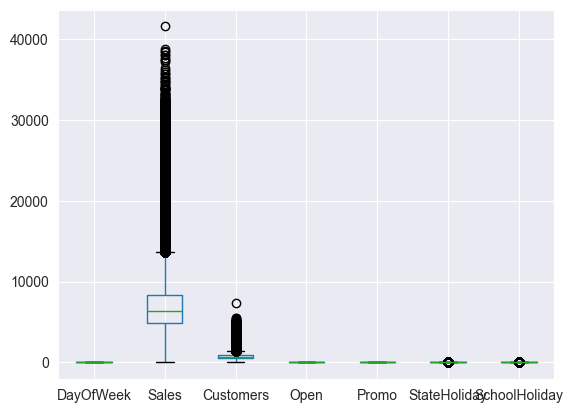

In [16]:
store_data.boxplot()

array([[<Axes: title={'center': 'Sales'}>]], dtype=object)

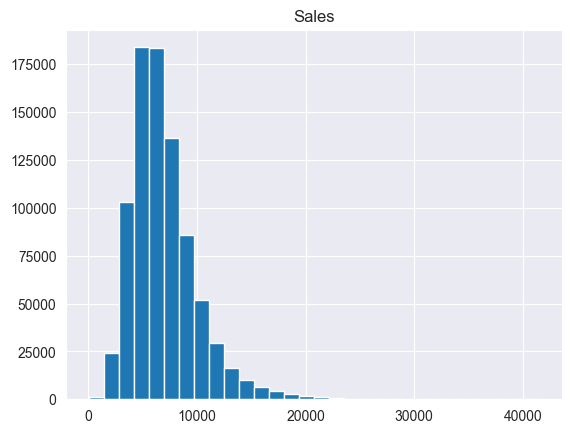

In [18]:
store_data.hist('Sales', bins=30)

array([[<Axes: title={'center': 'Sales'}>]], dtype=object)

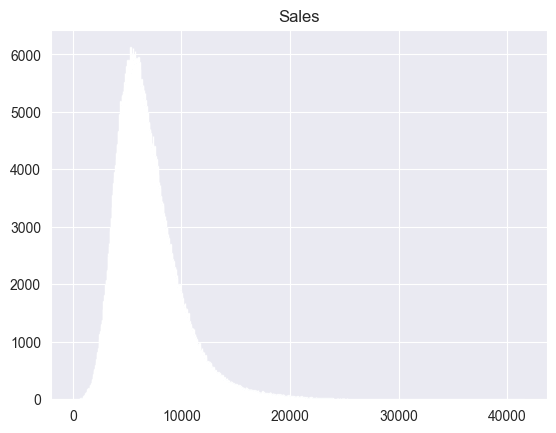

In [19]:
store_data.hist('Sales', bins=1000)

Na podstawie histogramów (pierwszy z małą ilością binów i drugi z dużą żeby zobaczyć dokładną dystrybucje danych) można stwierdzić że rozkład sprzedaży jest prawostronnie skośny oznacza to że wiele danych które mogą zostać potraktowane jako outliery (dane znajdujące się dalej prawej strony rozkładu, sugerując się medianą), mimo tego że nie oznacza to że dane te w istocie są outlierami na co trzeba uważać w kolejnych krokach. Znając zatem rozkład samego prognozowanego rodzaju danych możemy przejść do dalszej analizy tym razem na tle zależności pomiędzy danymi w zbiorze.


In [20]:
merged_df = store_data.copy()
merged_df = merged_df.merge(stores_df.reset_index(), on='Store', how='left')
merged_df.drop(['index'], axis=1, inplace=True)
merged_df = clear_df_from_nans(merged_df)
merged_df

C:\Users\szymo\AppData\Local\Temp\ipykernel_19552\3452603427.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.CompetitionDistance.fillna(stores_df.CompetitionDistance.mean(),inplace = True)
C:\Users\szymo\AppData\Local\Temp\ipykernel_19552\3452603427.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,State
0,1,5,2015-07-31,5263,555,1,1,0,1,0,0,1270.0,9.0,2008.0,0,13.0,2010.0,0,0
1,2,5,2015-07-31,6064,625,1,1,0,1,1,0,570.0,11.0,2007.0,1,13.0,2010.0,1,1
2,3,5,2015-07-31,8314,821,1,1,0,1,1,0,14130.0,12.0,2006.0,1,14.0,2011.0,1,2
3,4,5,2015-07-31,13995,1498,1,1,0,1,0,1,620.0,9.0,2009.0,0,1.0,2012.0,0,3
4,5,5,2015-07-31,4822,559,1,1,0,1,1,0,29910.0,4.0,2015.0,0,1.0,2012.0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844333,682,2,2013-01-01,3375,566,1,0,1,1,3,0,150.0,9.0,2006.0,0,22.0,2012.0,0,3
844334,733,2,2013-01-01,10765,2377,1,0,1,1,3,2,860.0,10.0,1999.0,0,36.0,2013.0,0,2
844335,769,2,2013-01-01,5035,1248,1,0,1,1,3,2,840.0,4.0,2015.0,1,48.0,2012.0,1,2
844336,948,2,2013-01-01,4491,1039,1,0,1,1,3,2,1430.0,3.0,2006.0,0,40.0,2011.0,0,8


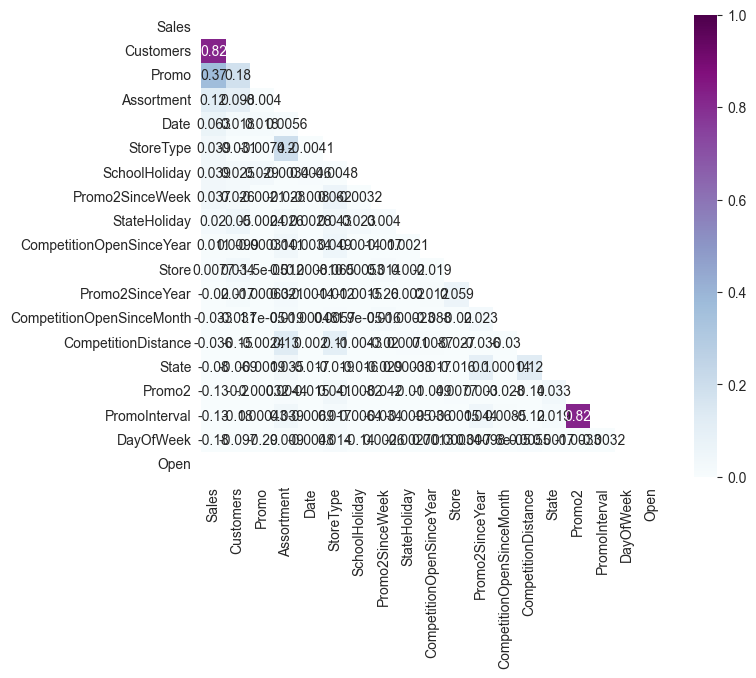

In [21]:
correlation_map(merged_df, 'Sales', len(merged_df.columns))

Ogólny wykres korelacji pozwala wysnuć pewne wnioski oraz przemyśleć możliwość tego które dane mogą od razu okazać się pomocne a które należy zweryfikować. Ku zaskoczeniu nikogo liczba klientów oraz trwająca promocja jest oczywiście najbardziej znaczącym elementem wpływającym na sprzedaż.

<Axes: xlabel='StoreType'>

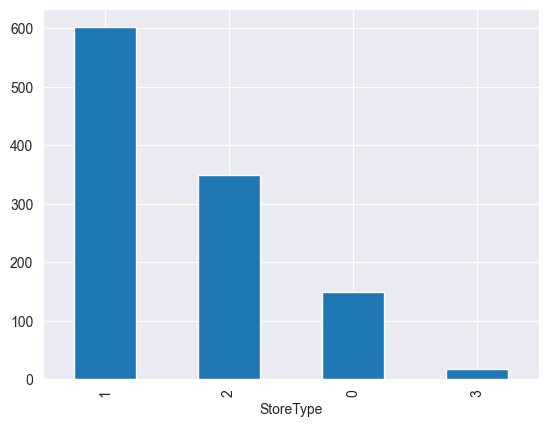

In [22]:
stores_df['StoreType'].value_counts().plot(kind='bar') # Sprawdzenie proporcji w jakiej rozkładają się dane typy

In [23]:
store_type_dict

{'c': 0, 'a': 1, 'd': 2, 'b': 3}

In [24]:
merged_df[['StoreType', 'Sales']].groupby('StoreType').agg('sum') # można zaobserować że istnieje pewna zależność jednak ciężko zdefiniować z czego ona wynika, natomiast same różnice są znaczące.

,Sales
StoreType,
0,783221426
1,3165334859
2,1765392943
3,159231395


<Axes: xlabel='StoreType'>

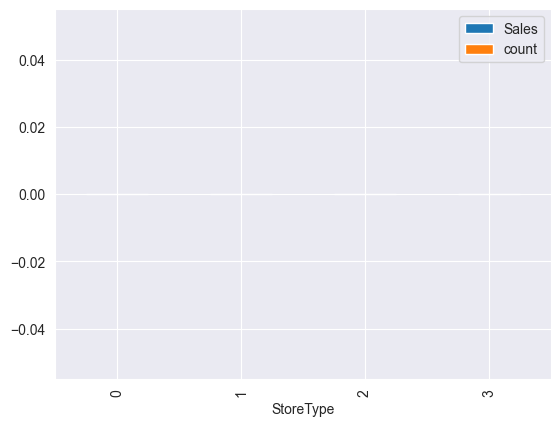

In [25]:
(merged_df[['StoreType', 'Sales']].groupby('StoreType').agg('sum') / pd.DataFrame(merged_df['StoreType'].value_counts()).rename(columns={'StoreType': 'Sales'})).plot(kind='bar')

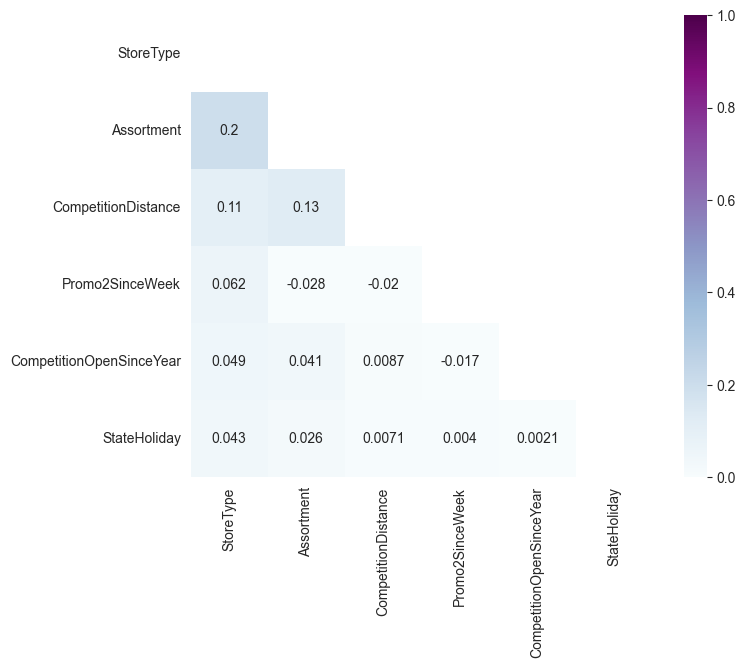

In [26]:
correlation_map(merged_df, 'StoreType', 6)

In [27]:
merged_df[['Assortment', 'Sales']].groupby('Assortment').agg('sum') 
# wyposażenie również posiada znaczące rozbieżności

,Sales
Assortment,
0,2945750070
1,2856484241
2,70946312


<Axes: xlabel='Assortment'>

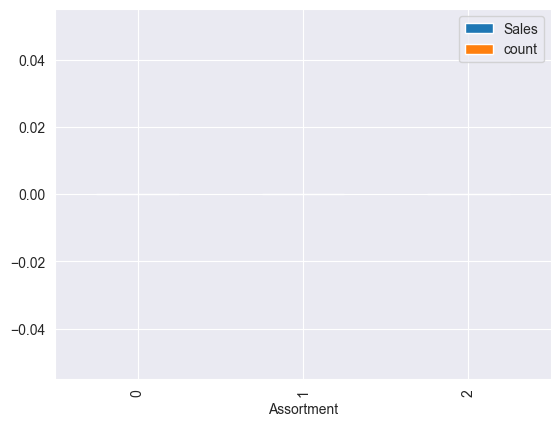

In [28]:
(merged_df[['Assortment', 'Sales']].groupby('Assortment').agg('sum')  / pd.DataFrame(merged_df['Assortment'].value_counts()).rename(columns={'Assortment': 'Sales'})).plot(kind="bar")

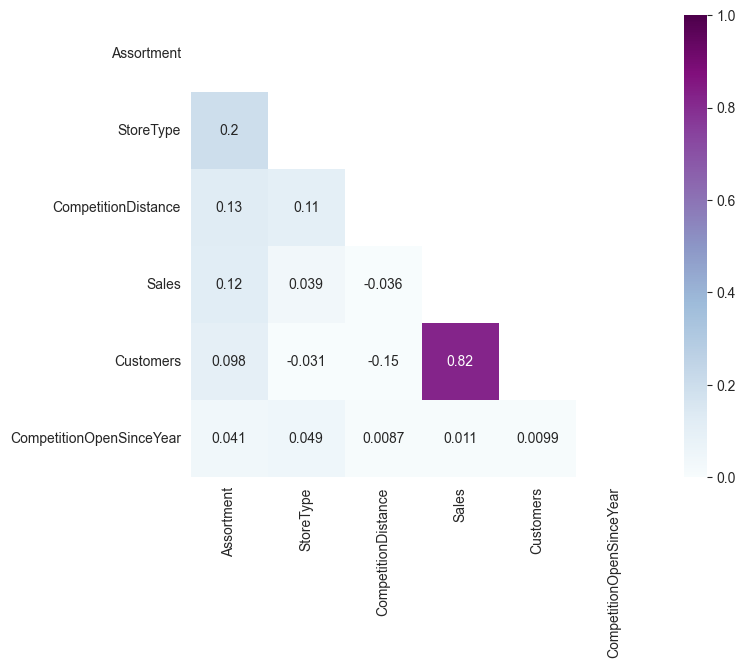

In [29]:
correlation_map(merged_df, 'Assortment', 6)

<Axes: xlabel='Assortment'>

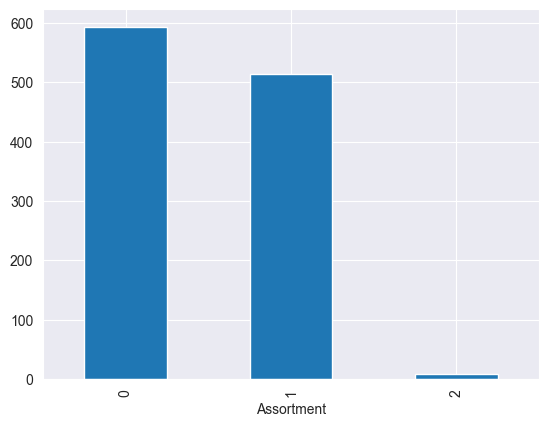

In [30]:
stores_df['Assortment'].value_counts().plot(kind='bar') # Sprawdzenie ilości sklepów z danej kategorii

Jak można zaobserwować obie zmienne są wzajemnie od siebie zależne jednak nie mają one znaczącego wpływu na sprzedaż, ponieważ jak można zaobserwować sprzedaż jest mocno powiązana z ilością tych sklepów. Jeżeli chodzi o obserwacje wynikające z ilości sprzedaży to można zaobserwować że po znormalizowaniu liczby sprzedaży przez wytępujące typy danych sklepów nie występuje znacząca różnica pomiędzy sprzedażą. Zarówno dla jednej jak i dla drugiej cechy mamy jeden typ który wyróżnia się spoza reszty natomiast pozostałe są wyrównane. Warto zauważyć natomiast że zależność asortymentu oraz typu sklepu może być mocno uzależniona od miejsca występowania takiego sklepu czyli być może samego landu lub miejsc takich jak dworce, galerie handlowe czy sklepy przyuliczne.

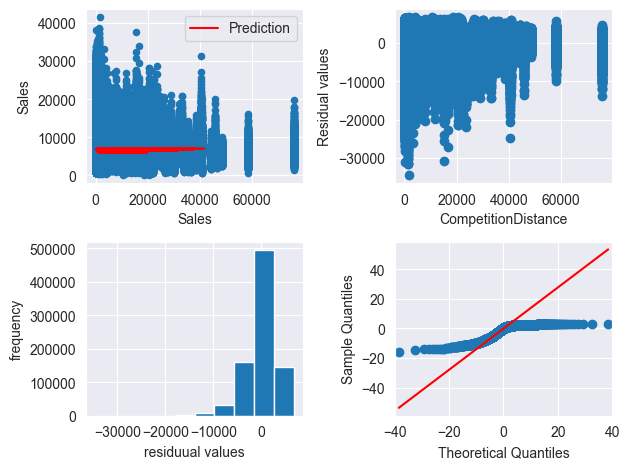

In [31]:
model, res = ols_two_cols(merged_df[['Sales', 'CompetitionDistance']].copy(), 'Sales', 'CompetitionDistance')

In [32]:
res.summary() # Wysoka szansa na to że wiele elementów modelu wpływa na sprzedaż, czyli najprawdopodobniej sam dystans nie ma aż tak znaczącego wpływu

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1120.
Date:                Mon, 22 Jan 2024   Prob (F-statistic):          1.92e-245
Time:                        21:48:59   Log-Likelihood:            -7.9863e+06
No. Observations:              844338   AIC:                         1.597e+07
Df Residuals:                  844336   BIC:                         1.597e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            7035.0224      4.120   1707.513      0.000    7026.947    7043.097
CompetitionDistance    -0.0145      0.000    -33.470      0.000      -0.015      -0.014
==============================================================================
Omnibus:                   277905.750   Durbin-Watson:                   1.473
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1163639.079
Skew:                           1.585   Prob(JB):                         0.00
Kurtosis:                       7.798   Cond. No.                     1.16e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.16e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

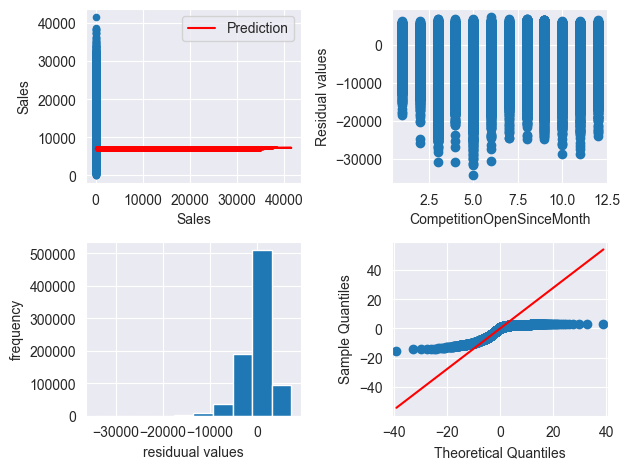

In [33]:
model, res = ols_two_cols_C(merged_df[['Sales', 'CompetitionOpenSinceMonth']].copy(), 'Sales', 'CompetitionOpenSinceMonth')

In [34]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     538.9
Date:                Mon, 22 Jan 2024   Prob (F-statistic):               0.00
Time:                        21:50:32   Log-Likelihood:            -7.9839e+06
No. Observations:              844338   AIC:                         1.597e+07
Df Residuals:                  844326   BIC:                         1.597e+07
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                             7263.1524     27.506    264.062      0.000    7209.242    7317.062
C(CompetitionOpenSinceMonth)[T.2.0]   -673.6885     30.765    -21.898      0.000    -733.987    -613.390
C(CompetitionOpenSinceMonth)[T.3.0]    -59.4981     29.451     -2.020      0.043    -117.221      -1.775
C(CompetitionOpenSinceMonth)[T.4.0]   -313.9004     29.285    -10.719      0.000    -371.298    -256.503
C(CompetitionOpenSinceMonth)[T.5.0]     -7.5972     30.548     -0.249      0.804     -67.469      52.275
C(CompetitionOpenSinceMonth)[T.6.0]    125.4570     30.486      4.115      0.000      65.706     185.208
C(CompetitionOpenSinceMonth)[T.7.0]   -411.1741     29.669    -13.859      0.000    -469.324    -353.024
C(CompetitionOpenSinceMonth)[T.8.0]    139.5614     31.306      4.458      0.000      78.203     200.920
C(CompetitionOpenSinceMonth)[T.9.0]   -335.1059     28.664    -11.691      0.000    -391.287    -278.925
C(CompetitionOpenSinceMonth)[T.10.0]  -400.5470     29.915    -13.390      0.000    -459.179    -341.915
C(CompetitionOpenSinceMonth)[T.11.0]  -744.7984     29.368    -25.361      0.000    -802.359    -687.238
C(CompetitionOpenSinceMonth)[T.12.0]  -421.7103     30.091    -14.014      0.000    -480.688    -362.732
==============================================================================
Omnibus:                   276223.386   Durbin-Watson:                   1.477
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1153260.206
Skew:                           1.576   Prob(JB):                         0.00
Kurtosis:                       7.780   Cond. No.                         29.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

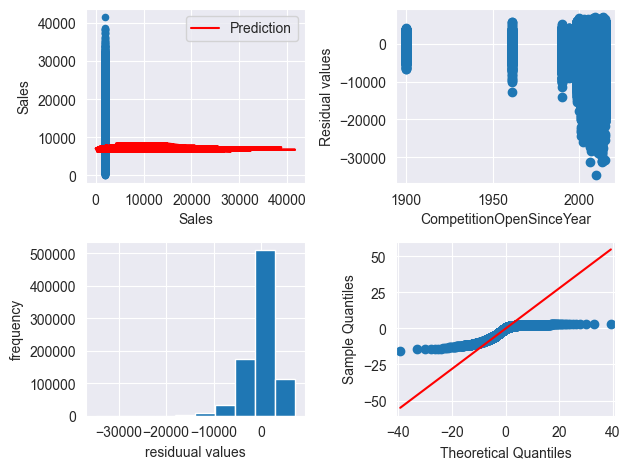

In [35]:
model, res = ols_two_cols_C(merged_df[['Sales', 'CompetitionOpenSinceYear']].copy(), 'Sales', 'CompetitionOpenSinceYear')

In [36]:
display(res.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     334.9
Date:                Mon, 22 Jan 2024   Prob (F-statistic):               0.00
Time:                        21:52:09   Log-Likelihood:            -7.9832e+06
No. Observations:              844338   AIC:                         1.597e+07
Df Residuals:                  844315   BIC:                         1.597e+07
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                              8395.8376    123.914     67.755      0.000    8152.971    8638.704
C(CompetitionOpenSinceYear)[T.1961.0]  -452.4132    141.779     -3.191      0.001    -730.296    -174.530
C(CompetitionOpenSinceYear)[T.1990.0] -1660.0079    130.112    -12.758      0.000   -1915.023   -1404.993
C(CompetitionOpenSinceYear)[T.1994.0] -1127.4581    146.657     -7.688      0.000   -1414.901    -840.015
C(CompetitionOpenSinceYear)[T.1995.0]  -937.0769    148.852     -6.295      0.000   -1228.823    -645.331
C(CompetitionOpenSinceYear)[T.1998.0]  -905.0791    166.801     -5.426      0.000   -1232.004    -578.154
C(CompetitionOpenSinceYear)[T.1999.0] -1763.9069    127.636    -13.820      0.000   -2014.069   -1513.745
C(CompetitionOpenSinceYear)[T.2000.0]  -730.9891    127.212     -5.746      0.000    -980.321    -481.657
C(CompetitionOpenSinceYear)[T.2001.0] -1881.1946    126.102    -14.918      0.000   -2128.351   -1634.039
C(CompetitionOpenSinceYear)[T.2002.0] -1884.7062    125.351    -15.035      0.000   -2130.390   -1639.022
C(CompetitionOpenSinceYear)[T.2003.0] -1049.7472    126.166     -8.320      0.000   -1297.029    -802.465
C(CompetitionOpenSinceYear)[T.2004.0] -2108.3798    125.723    -16.770      0.000   -2354.792   -1861.968
C(CompetitionOpenSinceYear)[T.2005.0] -1664.9893    124.458    -13.378      0.000   -1908.923   -1421.056
C(CompetitionOpenSinceYear)[T.2006.0] -1629.3400    124.668    -13.069      0.000   -1873.685   -1384.995
C(CompetitionOpenSinceYear)[T.2007.0] -1647.6932    124.633    -13.220      0.000   -1891.970   -1403.417
C(CompetitionOpenSinceYear)[T.2008.0] -1100.1366    124.507     -8.836      0.000   -1344.166    -856.107
C(CompetitionOpenSinceYear)[T.2009.0] -1192.8414    124.584     -9.575      0.000   -1437.022    -948.661
C(CompetitionOpenSinceYear)[T.2010.0] -1635.3391    124.533    -13.132      0.000   -1879.420   -1391.258
C(CompetitionOpenSinceYear)[T.2011.0] -1466.8703    124.484    -11.784      0.000   -1710.855   -1222.885
C(CompetitionOpenSinceYear)[T.2012.0] -1533.2316    124.352    -12.330      0.000   -1776.957   -1289.506
C(CompetitionOpenSinceYear)[T.2013.0] -1013.3119    124.361     -8.148      0.000   -1257.054    -769.569
C(CompetitionOpenSinceYear)[T.2014.0] -1338.9795    124.403    -10.763      0.000   -1582.806   -1095.154
C(CompetitionOpenSinceYear)[T.2015.0] -1500.6409    124.701    -12.034      0.000   -1745.051   -1256.231
==============================================================================
Omnibus:                   278435.662   Durbin-Watson:                   1.486
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1172325.781
Skew:                           1.587   Prob(JB):                         0.00
Kurtosis:  

In [37]:
extract = merged_df[(merged_df['Open'] == 1) & (merged_df['DayOfWeek'] == 7)]
display(sorted(extract.State.unique()))
display(merged_df.State.unique())
display(states_dict)

[0, 2, 3, 5, 6, 7, 8, 9, 11]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int64)

{'HE': 0,
 'TH': 1,
 'NW': 2,
 'BE': 3,
 'SN': 4,
 'SH': 5,
 'HB,NI': 6,
 'BY': 7,
 'BW': 8,
 'RP': 9,
 'ST': 10,
 'HH': 11}

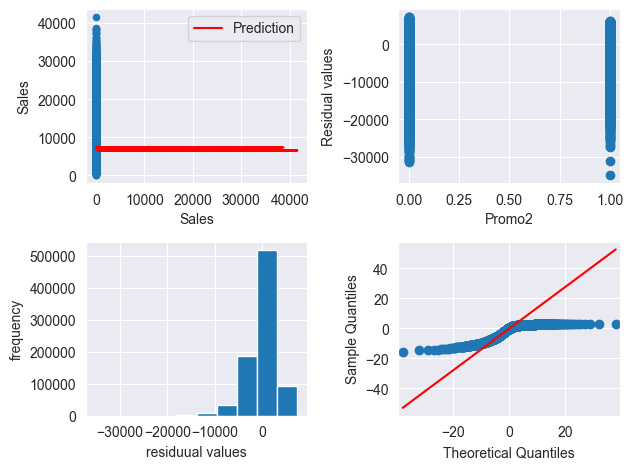

In [38]:
model, res = ols_two_cols_C(merged_df[['Sales', 'Promo2']].copy(), 'Sales', 'Promo2')

In [67]:
merged_df['Promo2'].corr(merged_df.Sales)

-0.12755631495619466

Wpływ przedłużonego okresu promocji co dziwne ma wpływ odwrotny względem zakładanego czyli w teorii zmniejsza proporcjonalnie sprzedaż. Warto zatem uwzględnić tą zależność w modelu w ramach danych kategorycznych.

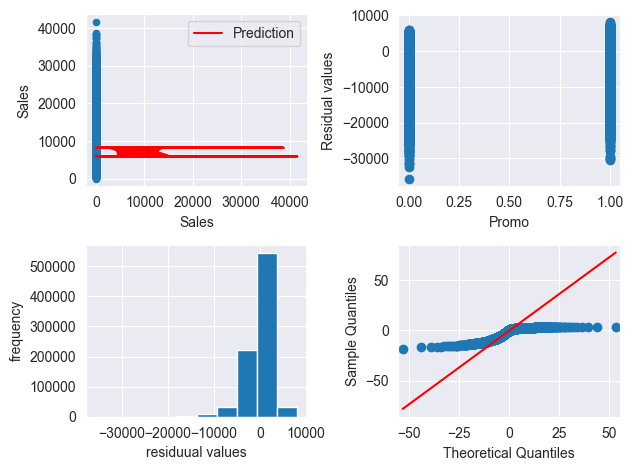

In [40]:
model, res = ols_two_cols_C(merged_df[['Sales', 'Promo']].copy(), 'Sales', 'Promo')

In [42]:
display(res.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                 1.324e+05
Date:                Mon, 22 Jan 2024   Prob (F-statistic):               0.00
Time:                        22:04:50   Log-Likelihood:            -7.9254e+06
No. Observations:              844338   AIC:                         1.585e+07
Df Residuals:                  844336   BIC:                         1.585e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      5929.8262      4.221   1404.930      0.000    5921.554    5938.099
C(Promo)[T.1]  2298.9135      6.318    363.895      0.000    2286.531    2311.296
==============================================================================
Omnibus:                   318967.168   Durbin-Watson:                   1.708
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1728206.584
Skew:                           1.746   Prob(JB):                         0.00
Kurtosis:                       9.077   Cond. No.                         2.51
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [66]:
merged_df['Promo'].corr(merged_df.Sales)

0.36819929047204275

Jak można zaobserwować po wynikach korelacji promocja znacząco wpływa na sprzedaż produktów. Nie przejawia się to jednocześnie niestety na samą zależność promocji i sprzedaży zgodnie z modelem regresji liniowej. Wynika to głównie z tego że podobnie co wiele innych danych jest to wartość kategoryczna co znacząco wpływa na trudność modelowania przebiegu w sposób liniowy. Można to zauważyć głownie po wartości omnibusa która jest bardzo wysoka oraz prawdopodobieństwa które jest zerowe.

In [77]:
merged_with_weather_df = merged_df.merge(weather.reset_index(), on='Date', how='left')
merged_with_weather_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,1,5,2015-07-31,5263,555,1,1,0,1,0,...,31.0,10.0,10.0,29.0,14.0,50.0,0.00,4.0,0.0,277.0
1,2,5,2015-07-31,6064,625,1,1,0,1,1,...,31.0,10.0,10.0,29.0,14.0,50.0,0.00,4.0,0.0,277.0
2,3,5,2015-07-31,8314,821,1,1,0,1,1,...,31.0,10.0,10.0,29.0,14.0,50.0,0.00,4.0,0.0,277.0
3,4,5,2015-07-31,13995,1498,1,1,0,1,0,...,31.0,10.0,10.0,29.0,14.0,50.0,0.00,4.0,0.0,277.0
4,5,5,2015-07-31,4822,559,1,1,0,1,1,...,31.0,10.0,10.0,29.0,14.0,50.0,0.00,4.0,0.0,277.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2218384,1097,2,2013-01-01,5961,1405,1,0,1,1,3,...,31.0,12.0,4.0,39.0,26.0,58.0,5.08,6.0,0.0,215.0
2218385,1097,2,2013-01-01,5961,1405,1,0,1,1,3,...,31.0,13.0,8.0,34.0,24.0,48.0,4.06,7.0,0.0,232.0
2218386,1097,2,2013-01-01,5961,1405,1,0,1,1,3,...,31.0,12.0,10.0,23.0,14.0,39.0,2.03,6.0,0.0,206.0
2218387,1097,2,2013-01-01,5961,1405,1,0,1,1,3,...,31.0,12.0,10.0,23.0,6.0,42.0,0.25,6.0,8.0,228.0


In [56]:
weather_event_dict

{'Rain': 0,
 'Fog-Rain-Snow': 1,
 'Rain-Snow': 2,
 'Rain-Thunderstorm': 3,
 'Rain-Snow-Hail': 4,
 'Snow': 5,
 'Fog': 6,
 'Fog-Rain-Thunderstorm': 7,
 'Fog-Rain': 8,
 'Rain-Snow-Hail-Thunderstorm': 9,
 'Rain-Hail': 10,
 'Rain-Hail-Thunderstorm': 11,
 'Fog-Thunderstorm': 12,
 'Thunderstorm': 13,
 'Fog-Snow': 14,
 'Rain-Snow-Thunderstorm': 15,
 'Fog-Rain-Hail-Thunderstorm': 16,
 'Snow-Hail': 17,
 'Fog-Rain-Snow-Hail': 18}

In [78]:
values_weather = []
for key in weather_event_dict.keys():
    if key.endswith('Thunderstorm'):
        values_weather.append(weather_event_dict[key])

In [79]:
merged_with_weather_df['Events'].corr(merged_with_weather_df.Sales)

0.0026520514060742375

In [80]:
thunders_only = merged_with_weather_df[merged_with_weather_df['Events'].isin(values_weather)]

In [81]:
thunders_only['Events'].corr(thunders_only.Sales)

0.02963353860118558

In [83]:
simplified_events = merged_with_weather_df.copy()
simplified_events['EventsSimple'] = 0
simplified_events.iloc[merged_with_weather_df['Events'].isin(values_weather)] = 1
simplified_events['EventsSimple'].corr(simplified_events.Sales)

C:\Users\szymo\AppData\Local\Temp\ipykernel_19552\2048145382.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  simplified_events.iloc[merged_with_weather_df['Events'].isin(values_weather)] = 1


-0.6055173634022541

Jak można zauważyć istnieje pewna zależność pomiędzy sprzedażą a samymi zjawiskami pogodowymi jednak zależność ta jest na tyle niska że można zignorować prawie całkowicie sam wpływ zjawiska pogodowego. Jednak analizując pogodę pod kątem gorszych warunków pogodowych takich jak burza zależność znacząco wzrasta warto zatem rozważyć uproszczenie formy danych do mniejszej ilości zenkodowanych wartości przykładowo na zjawisko burzy lub bez burzy. Zmieniając dane tak aby reprezentowały postać uproszczoną można uzyskać wynik który bardzo dobrze reprezentuje negatywną zależność zjawiska pogodowego burzy względem pozostałych. Zinterpretowanie nowej formy cech można zinterpretować tak że jeżeli występuje burza to mamy bardzo duże szanse na to aby nie udać się do sklepu


In [88]:
merged_df['DayOfWeek'].corr(merged_df.Sales)

-0.17875313107919025

In [ ]:
store_data['DayOfWeek'].value_counts()

In [116]:
store_data.pivot_table(index='DayOfWeek', values='Sales', aggfunc=['sum'])['sum']['Sales'] / store_data['DayOfWeek'].value_counts()

DayOfWeek
1    8216.252259
2    7088.409086
3    6728.786679
4    6768.214973
5    7073.034133
6    5875.084935
7    8224.723908
dtype: float64

In [119]:
simplified_day_of_week = merged_df.copy()
simplified_day_of_week[simplified_day_of_week['DayOfWeek'] != 7] = 1
simplified_day_of_week[simplified_day_of_week['DayOfWeek'] == 7] = -1
simplified_day_of_week.DayOfWeek.corr(simplified_day_of_week.Sales)

C:\Users\szymo\AppData\Local\Temp\ipykernel_19552\747293088.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  simplified_day_of_week[simplified_day_of_week['DayOfWeek'] != 7] = 1


1.0

Jak można zaobserwować dane tygodnia są problematycznym przypadkiem. po pierwsze występują ogromne rozbieżności w liczebności wystąpień wszystkich dni tygodnia a niedzieli. W związku z tym występuje problem ważenia tych danych, po którym z kolei można zaobserwować że sprzedaż w niedzielę jest rzeczywiście bardzo wysoka. Jednocześnie po całkowitym porzuceniu niedzieli można zaobserwować wysoką korelację pozostałych dni tygodnia względem poprzedniego przypadku ponieważ bardzo mało ilość niedzieli w zbiorze sprawia że mała waga sprzedaży jest praktycznie niezauważalna na tle pozostałych dni tygodnia.